In [1]:
import os
from dotenv import load_dotenv

import pandas as pd
import pandas_gbq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

import itertools as it

load_dotenv()
project_id = os.getenv("PROJECT_ID")

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

TOWERS = ["tower_A", "tower_B", "tower_C", "tower_D"]
METRIC = "computer_vision_tracking_latency_ms"

**NOTE**: See the profiled `computer_vision_tracking_latency_ms` [here](https://storage.googleapis.com/anduril-case-study/metrics/computer_vision_tracking_latency_ms.html).

In [2]:
# Get data
df = pandas_gbq.read_gbq(
    f"select * from metrics.{METRIC}",
    project_id=project_id,
    use_bqstorage_api=True,
)

query = f"""
select
  ts,
  tower_id,
  metric_name,
  metric_value
from `raw_data.long_clean`
where metric_name = '{METRIC}'
"""
df_long_clean = pandas_gbq.read_gbq(
    query,
    project_id=project_id,
    use_bqstorage_api=True,
)

df.set_index("ts", inplace=True)
df.drop(columns=["timestamp_ms"], inplace=True)
df.sort_index(inplace=True)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88339 entries, 2024-01-18 04:48:30+00:00 to 2024-02-17 20:57:30+00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tower_A  86026 non-null  float64
 1   tower_B  21173 non-null  float64
 2   tower_C  19704 non-null  float64
 3   tower_D  20024 non-null  float64
dtypes: float64(4)
memory usage: 3.4 MB


In [4]:
df_long_clean['metric_value'].describe()

count    146927.000000
mean        127.059344
std         110.107277
min          32.000000
25%          69.250000
50%          96.000000
75%         122.333333
max        1330.000000
Name: metric_value, dtype: float64

In [5]:
df.describe()

,tower_A,tower_B,tower_C,tower_D
count,86026.000000,21173.000000,19704.000000,20024.000000
mean,143.698276,102.630518,63.617568,143.834588
std,101.248355,53.296755,4.622525,189.292629
min,71.500000,66.083333,32.000000,32.000000
25%,96.666667,74.416667,60.666667,61.083333
50%,117.000000,81.500000,62.083333,63.166667
75%,127.666667,91.000000,65.500000,69.000000
max,565.000000,545.416667,265.800000,1330.000000


In [6]:
df['day'] = df.index.date
df_long = df.melt('day', TOWERS)
df.drop('day', axis=1, inplace=True)
df_long_avgs = df_long.merge(df.mean().rename('mean'), left_on='variable', right_index=True)

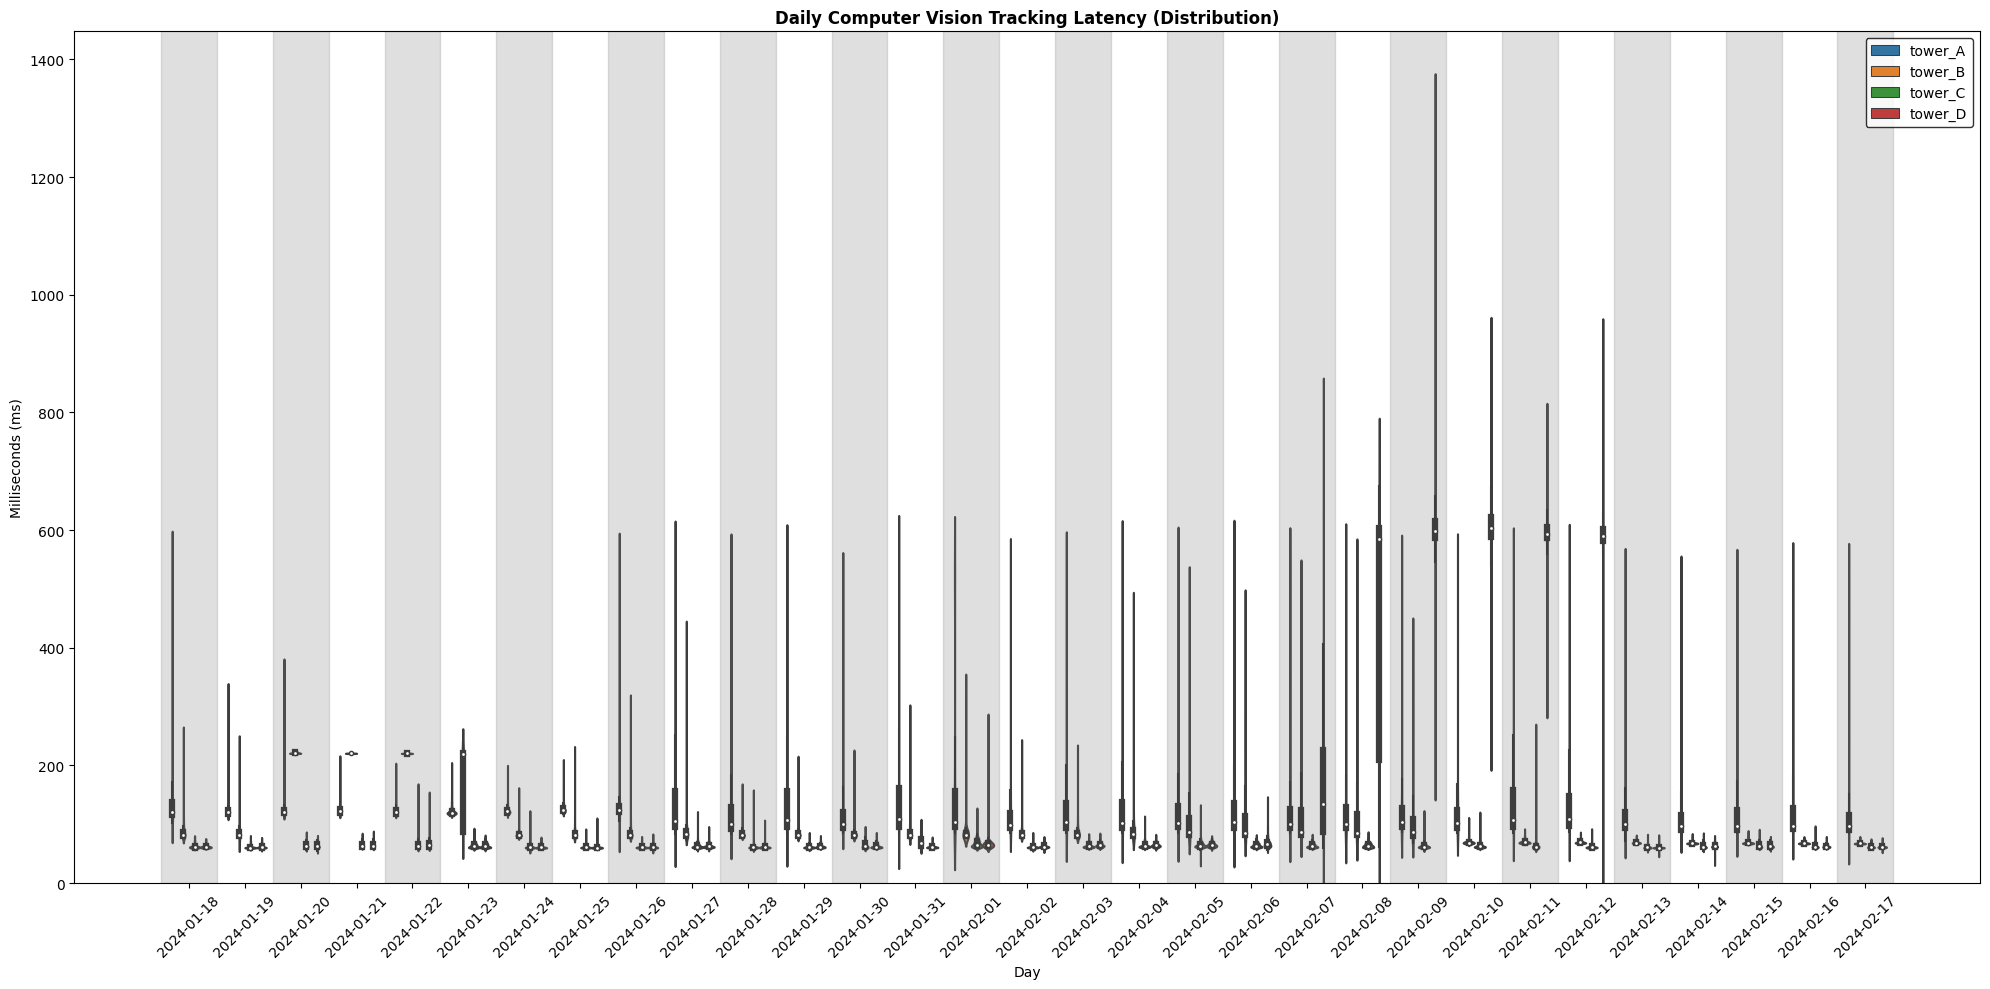

In [7]:
plt.figure(figsize=(20, 10))
ax = sns.violinplot(x='day', y='value', hue='variable', data=df_long, inner='box')

# Adding alternating shading
for i, day in enumerate(df_long['day'].unique()):
    if i % 2 == 0:
        ax.axvspan(i-0.5, i+0.5, color='grey', alpha=0.25)

plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.title('Daily Computer Vision Tracking Latency (Distribution)', weight='bold')
plt.xlabel('Day')
plt.ylabel('Milliseconds (ms)')
plt.tight_layout()
plt.legend(title='Tower')
legend = plt.gca().legend().get_frame()
legend.set_linewidth(1)
legend.set_edgecolor('black')
plt.tight_layout()
plt.show()

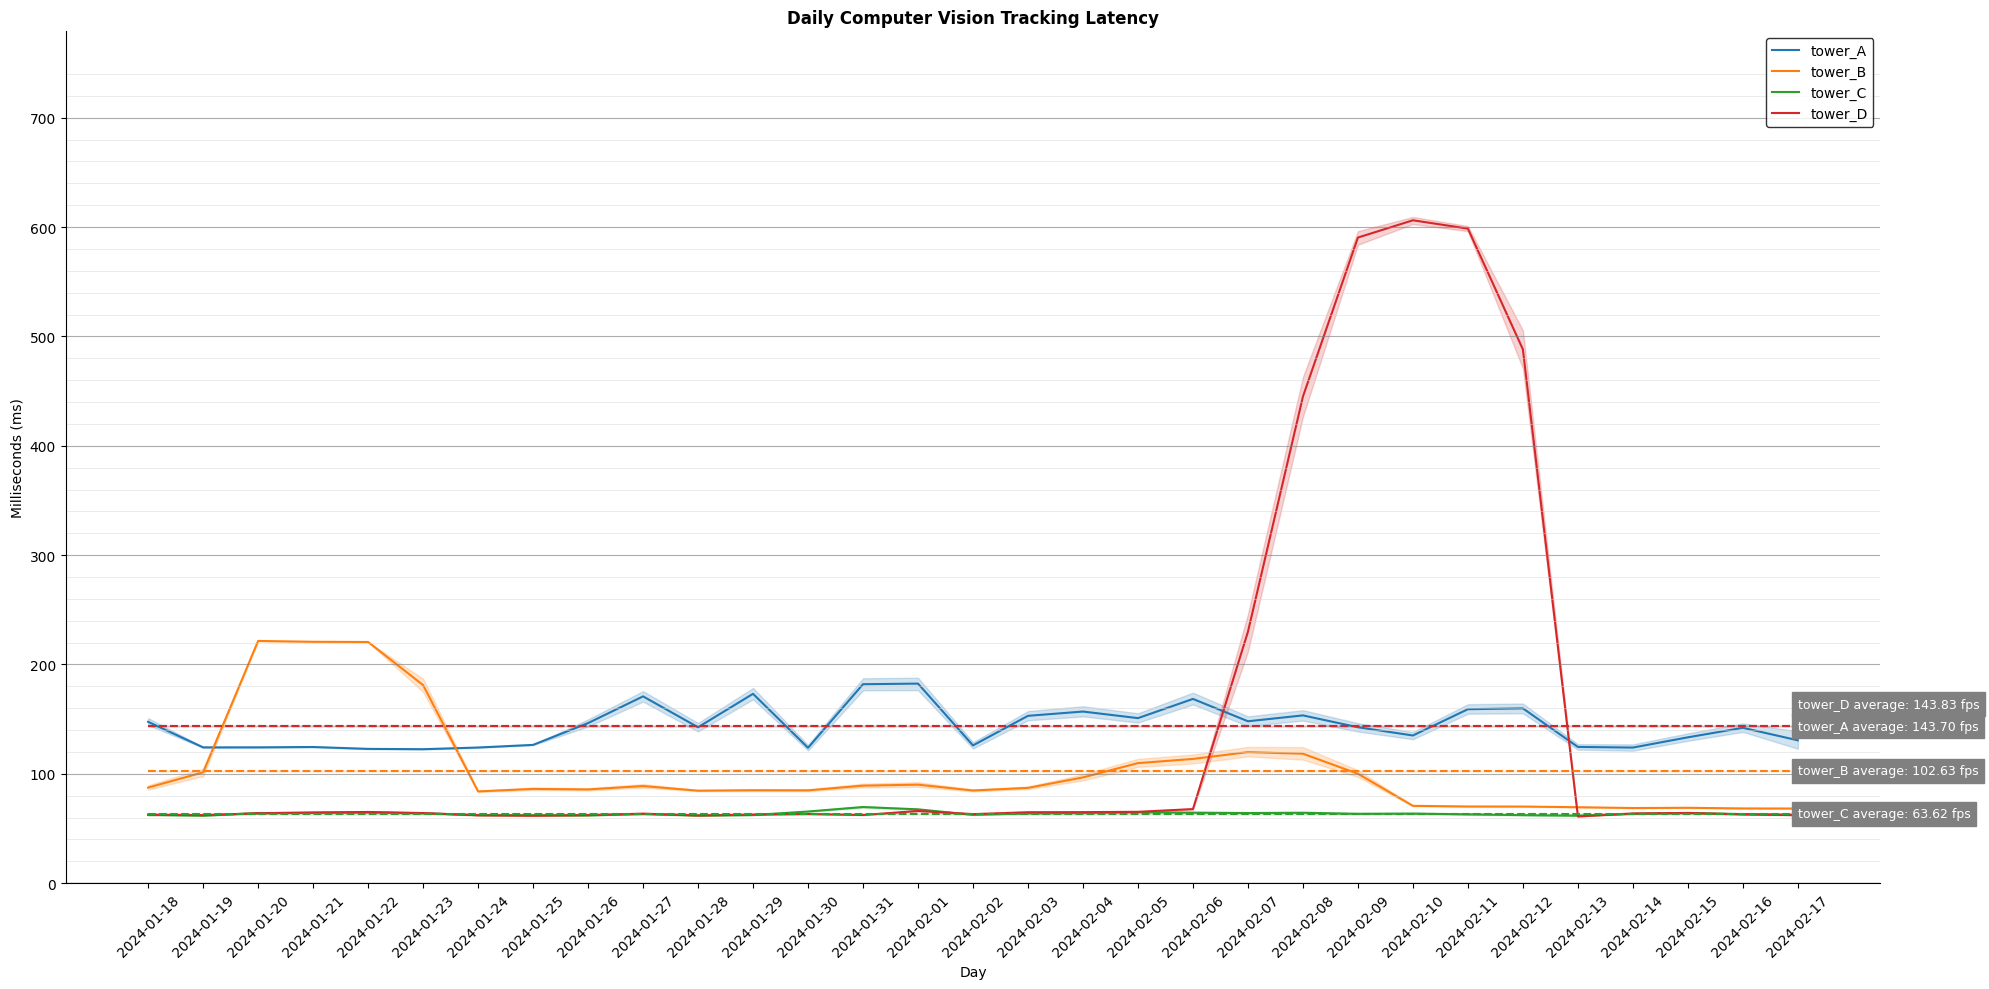

In [8]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(x='day', y='value', hue='variable', data=df_long)
ax = sns.lineplot(x='day', y='mean', hue='variable', linestyle='--', legend=False, data=df_long_avgs, ax=ax)

for tower in TOWERS:
    mean_value = df_long_avgs[df_long_avgs['variable'] == tower]['mean'].iloc[0]
    ax.text(x=df_long['day'].max(), y=mean_value + (20 if tower == 'tower_D'  else 0), s=f'{tower} average: {mean_value:.2f} fps', 
            color='white', va='center', ha='left', fontsize=9).set_backgroundcolor('grey')

ax.minorticks_on()
for y in ax.get_yticks():
    lw, a = (0.8, 0.65) if y != 0 else (1, 1)
    ax.axhline(y=y, color='grey', linestyle='-', linewidth=lw, alpha=a)
for y in ax.get_yticks(minor=True):
    ax.axhline(y=y, color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.65)
ax.minorticks_off()

ax.set_xticks(x_values := df_long['day'].unique())
ax.set_xticklabels(x_values, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.title('Daily Computer Vision Tracking Latency', weight='bold')
plt.xlabel('Day')
plt.ylabel('Milliseconds (ms)')
plt.tight_layout()
plt.legend(title='Tower')
legend = plt.gca().legend().get_frame()
legend.set_linewidth(1)
legend.set_edgecolor('black')
plt.tight_layout()
plt.show()

In [9]:
df.resample('1d').agg(['mean', 'sem'])

tower_A               tower_B            \
                                 mean       sem        mean       sem   
ts                                                                      
2024-01-18 00:00:00+00:00  147.540979  1.679433   87.410038  1.036284   
2024-01-19 00:00:00+00:00  124.164294  0.252657  101.374644  1.744290   
2024-01-20 00:00:00+00:00  124.200926  0.202488  221.511576  0.040723   
2024-01-21 00:00:00+00:00  124.521238  0.158178  220.744792  0.016343   
2024-01-22 00:00:00+00:00  122.801389  0.146984  220.559038  0.018339   
2024-01-23 00:00:00+00:00  122.499884  0.152272  181.134181  3.115898   
2024-01-24 00:00:00+00:00  124.046306  0.148805   83.905926  0.299736   
2024-01-25 00:00:00+00:00  126.457350  0.141026   86.214002  0.566060   
2024-01-26 00:00:00+00:00  146.380386  1.644540   85.733861  0.510692   
2024-01-27 00:00:00+00:00  170.826560  2.557783   88.808562  0.925142   
2024-01-28 00:00:00+00:00  142.577743  1.965625   84.565781  0.287943   
2024-01-29 00:00:00+00:00  173.158907  2.591875   84.978072  0.435778   
2024-01-30 00:00:00+00:00  123.811038  1.260451   84.881627  0.480110   
2024-01-31 00:00:00+00:00  181.952720  2.808176   89.175312  0.842576   
2024-02-01 00:00:00+00:00  182.497568  2.895803   90.093485  1.072222   
2024-02-02 00:00:00+00:00  125.968866  1.464329   84.732923  0.479466   
2024-02-03 00:00:00+00:00  153.038426  2.217976   87.135335  0.640021   
2024-02-04 00:00:00+00:00  156.939552  2.343965   96.715956  1.451356   
2024-02-05 00:00:00+00:00  150.927670  2.207613  109.785697  1.999000   
2024-02-06 00:00:00+00:00  168.479442  2.681758  113.608167  2.213489   
2024-02-07 00:00:00+00:00  148.053326  2.251402  119.832297  2.334379   
2024-02-08 00:00:00+00:00  153.423169  2.416816  118.381880  2.860324   
2024-02-09 00:00:00+00:00  142.592560  1.949824  100.051787  1.608595   
2024-02-10 00:00:00+00:00  135.048438  1.773858   70.713424  0.210394   
2024-02-11 00:00:00+00:00  159.080494  2.177154   70.119982  0.106763   
2024-02-12 00:00:00+00:00  159.833854  2.257144   70.060503  0.101868   
2024-02-13 00:00:00+00:00  124.581082  1.310820   69.459146  0.083709   
2024-02-14 00:00:00+00:00  124.001563  1.482383   68.715046  0.090730   
2024-02-15 00:00:00+00:00  133.368637  1.811416   68.925557  0.096908   
2024-02-16 00:00:00+00:00  142.073611  2.021195   68.343460  0.066529   
2024-02-17 00:00:00+00:00  130.639515  3.916151   68.250552  0.099293   

                             tower_C               tower_D            
                                mean       sem        mean       sem  
ts                                                                    
2024-01-18 00:00:00+00:00  62.588789  0.343055   62.634384  0.267818  
2024-01-19 00:00:00+00:00  61.686874  0.105431   62.239649  0.119765  
2024-01-20 00:00:00+00:00  64.127643  0.136847   63.888573  0.136888  
2024-01-21 00:00:00+00:00  64.296764  0.135731   64.676973  0.153686  
2024-01-22 00:00:00+00:00  64.619241  0.226327   65.101063  0.200001  
2024-01-23 00:00:00+00:00  63.941939  0.147250   64.116156  0.143919  
2024-01-24 00:00:00+00:00  62.210164  0.147321   62.081598  0.117593  
2024-01-25 00:00:00+00:00  62.065618  0.118866   61.685030  0.129162  
2024-01-26 00:00:00+00:00  61.975040  0.104375   62.235598  0.115798  
2024-01-27 00:00:00+00:00  63.234914  0.150126   63.580369  0.134099  
2024-01-28 00:00:00+00:00  61.836806  0.174520   61.913329  0.116184  
2024-01-29 00:00:00+00:00  62.288919  0.128087   62.730235  0.113110  
2024-01-30 00:00:00+00:00  65.526883  0.256711   63.250236  0.139184  
2024-01-31 00:00:00+00:00  69.633427  0.315238   62.326837  0.105799  
2024-02-01 00:00:00+00:00  67.516936  0.280256   66.036162  0.384047  
2024-02-02 00:00:00+00:00  62.487244  0.112856   63.124177  0.118384  
2024-02-03 00:00:00+00:00  63.819871  0.140398   64.884173  0.132361  
2024-02-04 00:00:00+00:00  64.120482  0.147652   64.953861  0.137428  
2024-02-05 00:00:00+00:00  64.865861  0.188480   65.2472